In [1]:
# general purpose python
import collections
import datetime
import glob
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch device:    ', device.type)

# geospatial
import rasterio as rio
import rasterio.features

ignore_warnings = True
if ignore_warnings:
    warnings.filterwarnings('ignore')
print('ignore warnings:   ', ignore_warnings)

seed = 1337
np.random.seed(seed)
print('random seed:       ', seed)

mpl.rcParams['figure.dpi'] = 400

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

pytorch device:     cuda
ignore warnings:    True
random seed:        1337


### Prepare the data

In [2]:
batch_size = 64

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

train_dataset = torchvision.datasets.MNIST(root='../data/torchvision_data_root',
                                           train=True,
                                           download=True,
                                           transform=img_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='../data/torchvision_data_root',
                                          train=False,
                                          download=True,
                                          transform=img_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

### Build the autoencoder

In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2),
            nn.Conv2d(
                in_channels=8,
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2),
            nn.Flatten(),
            nn.Linear(in_features=8*7*7,
                      out_features=64),
            nn.Linear(in_features=64,
                      out_features=16))
        
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=16,
                out_features=64),
            nn.Linear(
                in_features=64,
                out_features=8*7*7),
            Reshape(-1, 8, 7, 7),
            nn.ConvTranspose2d(
                in_channels=8,
                out_channels=8,
                kernel_size=2,
                stride=2,
                padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=8,
                out_channels=1,
                kernel_size=2,
                stride=2,
                padding=0),
            nn.Tanh()
        )
        print('encoder:', self.encoder)
        print('decoder:', self.decoder)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, h):
        return self.decoder(h)
        
    def forward(self, x):
        h = self.encode(x)
        y = self.decode(h)
        return y
    
model = AutoEncoder().to(device)

encoder: Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=392, out_features=64, bias=True)
  (8): Linear(in_features=64, out_features=16, bias=True)
)
decoder: Sequential(
  (0): Linear(in_features=16, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=392, bias=True)
  (2): Reshape()
  (3): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (4): ReLU(inplace=True)
  (5): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
  (6): Tanh()
)


### Training

In [4]:
def apply_noise(x):
    return torch.clamp(x + torch.clamp(2 * torch.round(0.4 * torch.randn(x.shape)), -2, 2), -1, 1)

epoch:  1/ 25        train loss:    0.3288        test loss:    0.2704
epoch:  5/ 25        train loss:    0.1337        test loss:    0.1259
epoch: 10/ 25        train loss:    0.1007        test loss:    0.0965
epoch: 15/ 25        train loss:    0.0877        test loss:    0.0847
epoch: 20/ 25        train loss:    0.0822        test loss:    0.0798
epoch: 25/ 25        train loss:    0.0790        test loss:    0.0767


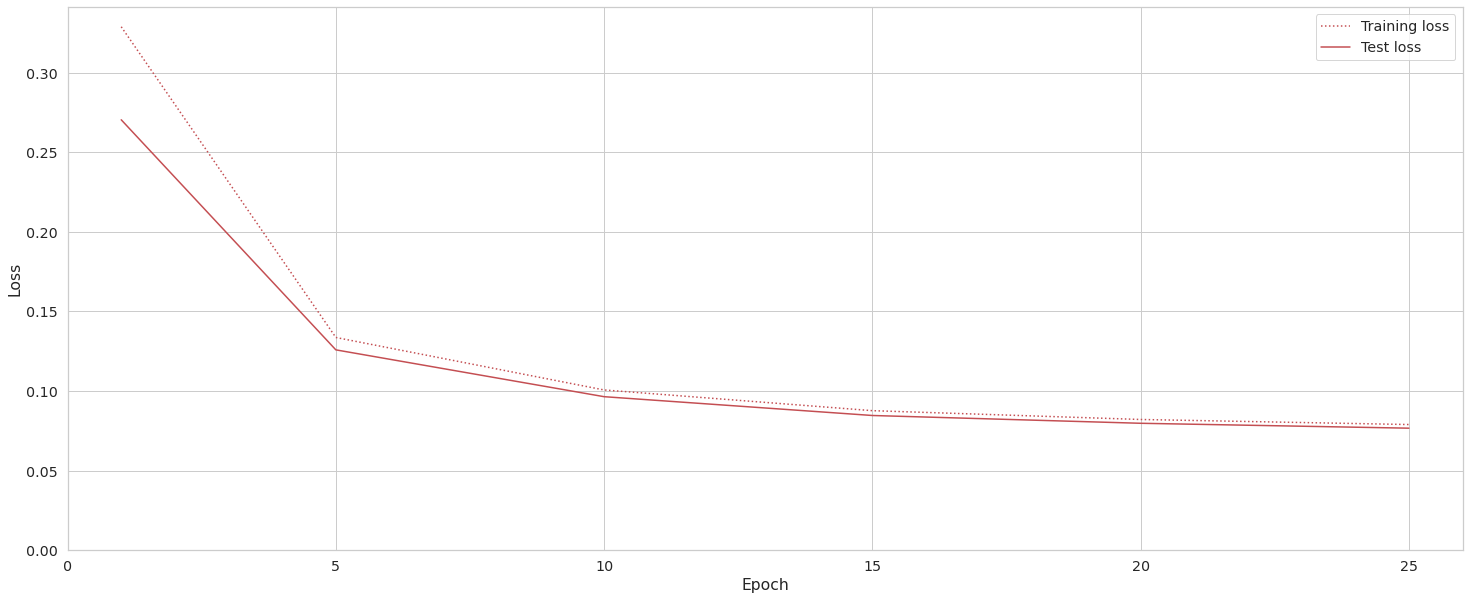

In [5]:
model_path = 'model_04.pth'
try:
    model.load_state_dict(torch.load(model_path))
except:
    n_epochs = 25
    learning_rate = 1e-4
    weight_decay = 1e-5

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay)

    training_history = {
        'epoch': [],
        'train_loss': [],
        'test_loss': []}

    for epoch in range(n_epochs):
        train_loss = 0
        for i, train_data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, _ = train_data
            x_noisy = apply_noise(x)
            x = torch.autograd.Variable(x).to(device)
            x_noisy = torch.autograd.Variable(x_noisy).to(device)
            y = model(x_noisy)
            l = criterion(x, y)
            train_loss += l.data.item()
            l.backward()
            optimizer.step()
        train_loss /= i + 1
        if epoch == 0 or (epoch + 1) % 5 == 0:
            with torch.no_grad():
                test_loss = 0
                for i, test_data in enumerate(test_loader, 0):
                    x, _ = test_data
                    x_noisy = apply_noise(x)
                    x = torch.autograd.Variable(x).to(device)
                    x_noisy = torch.autograd.Variable(x_noisy).to(device)
                    y = model(x_noisy)
                    l = criterion(x, y)
                    test_loss += l.data.item()
                test_loss /= i + 1
            training_history['epoch'].append(epoch + 1)
            training_history['train_loss'].append(train_loss)
            training_history['test_loss'].append(test_loss)
            print(f'epoch:{epoch + 1:3d}/{n_epochs:3d}        train loss:{train_loss:10.4f}        test loss:{test_loss:10.4f}')
    torch.save(model.state_dict(), model_path)
    
    plt.figure(figsize=(25, 10))
    plt.plot(training_history['epoch'],
             training_history['train_loss'],
             linestyle=':',
             c='r',
             label='Training loss')
    plt.plot(training_history['epoch'],
             training_history['test_loss'],
             c='r',
             label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, max(training_history['epoch']) + 1)
    plt.ylim(0, None)
    plt.legend()
    plt.show()

# Visualize results

### Image reconstruction

In [6]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

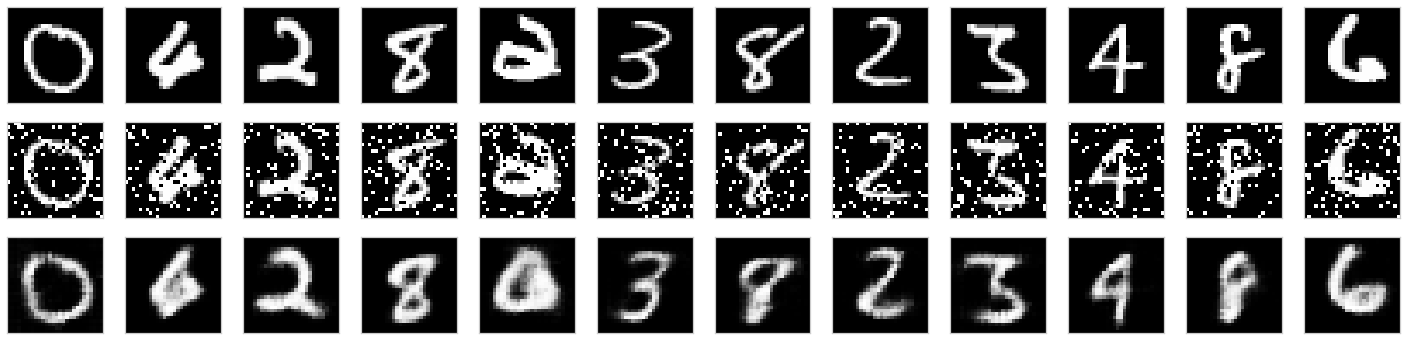

In [7]:
x, _ = next(iter(test_loader))
x_noisy = apply_noise(x)
x = torch.autograd.Variable(x).to(device)
x_noisy = torch.autograd.Variable(x_noisy).to(device)
y = model(x_noisy)

x = to_img(x.cpu().data)
x_noisy = to_img(x_noisy.cpu().data)
y = to_img(y.cpu().data)
d = [x, x_noisy, y]

plt.figure(figsize=(25, 6))
for i in range(3):
    for j in range(12):
        plt.subplot(3, 12, j + 1 + i*12)
        plt.imshow(d[i][j][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

### Reconstruction on non-MNIST images from CIFAR

Files already downloaded and verified


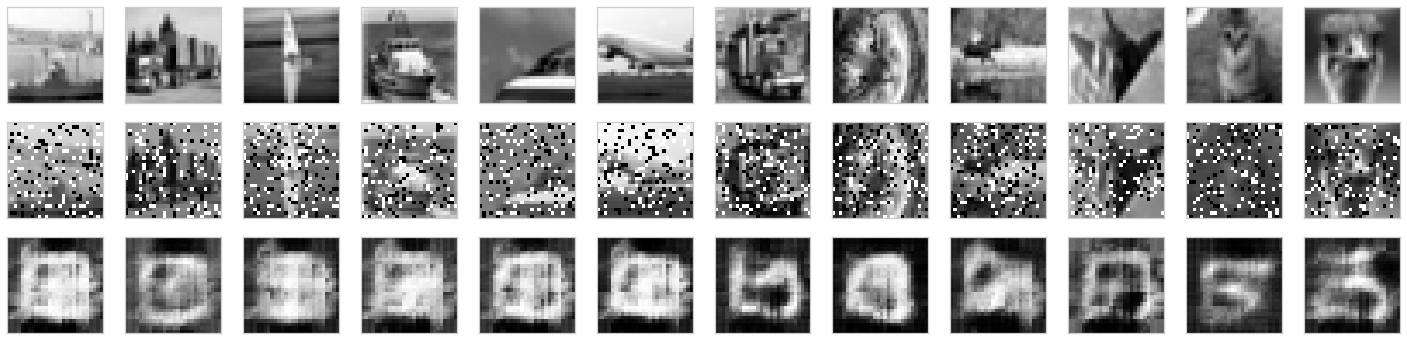

In [8]:
cifar_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.CenterCrop(28),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

cifar_dataset = torchvision.datasets.CIFAR10(root='../data/torchvision_data_root',
                                             train=True,
                                             download=True,
                                             transform=cifar_transform)

cifar_loader = torch.utils.data.DataLoader(cifar_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

x, _ = next(iter(cifar_loader))
x_noisy = apply_noise(x)
x = torch.autograd.Variable(x).to(device)
x_noisy = torch.autograd.Variable(x_noisy).to(device)
y = model(x_noisy)

x = to_img(x.cpu().data)
x_noisy = to_img(x_noisy.cpu().data)
y = to_img(y.cpu().data)
d = [x, x_noisy, y]

plt.figure(figsize=(25, 6))
for i in range(3):
    for j in range(12):
        plt.subplot(3, 12, j + 1 + i*12)
        plt.imshow(d[i][j][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()

# Generating output from a random representation

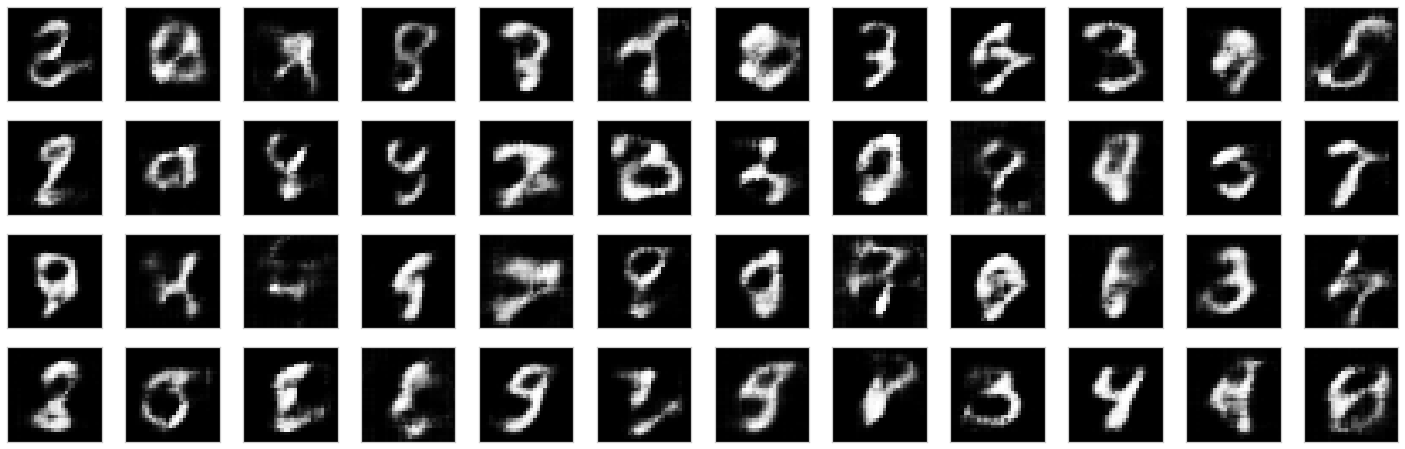

In [9]:
batches = []
for i, test_data in enumerate(test_loader, 0):
    x, _ = test_data
    x_noisy = apply_noise(x)
    x = torch.autograd.Variable(x).to(device)
    x_noisy = torch.autograd.Variable(x_noisy).to(device)
    h = model.encode(x_noisy)
    batches.append(h.detach().cpu().numpy())
a = np.concatenate(batches)

for i in range(16):
    np.random.shuffle(a[:,i])

h = torch.from_numpy(a[:64])
h = torch.autograd.Variable(h).to(device)

y = model.decode(h)
y = to_img(y.cpu().data)

plt.figure(figsize=(25, 8))
for i in range(4):
    for j in range(12):
        plt.subplot(4, 12, j + 1 + i*12)
        plt.imshow(y[j + i*12][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()